## CNN with transformer-based model
Xiaoning Zhu and Miguel Xochicale
 



In [ ]:
!pip install tokenizers
import nltk
nltk.download('punkt')
pip install matplotlib seaborn

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
import pandas as pd
import tensorflow as tf
import argparse
import imageio
import glob
import os
import datetime
from tokenizers import ByteLevelBPETokenizer
import cv2
from tqdm import tqdm
from builtins import range, dict
import sys, math, re
from collections import defaultdict
import copy
import numpy as np
import pdb
import math
import subprocess
import tempfile
import itertools
import string
from builtins import dict
from nltk import sent_tokenize, word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import argparse
import json
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# load data

In [ ]:
# The data generated from cnn+rnn model
train=pd.read_csv("/content/drive/MyDrive/dissertation/Transformer/train_t_data.csv")
vali=pd.read_csv("/content/drive/MyDrive/dissertation/Transformer/val_t_data.csv")
test=pd.read_csv("/content/drive/MyDrive/dissertation/Transformer/test_t_data.csv")

In [ ]:
# remove strtseq and endseq which work for LSTM decoder, they are useless in transformer model
train["Report"] = train["Report"].str.replace('startseq', '').str.replace('endseq', '')
vali["Report"] = vali["Report"].str.replace('startseq', '').str.replace('endseq', '')
test["Report"] = test["Report"].str.replace('startseq', '').str.replace('endseq', '')

In [ ]:
# change the image file path
def remove_image_prefix(file_path):
    return file_path.split('/')[1]

# Apply the function to the entire column
train["Image1"] = train["Image1"].apply(remove_image_prefix)
vali["Image1"] = vali["Image1"].apply(remove_image_prefix)
test["Image1"] = test["Image1"].apply(remove_image_prefix)
train["Image2"] = train["Image2"].apply(remove_image_prefix)
vali["Image2"] = vali["Image2"].apply(remove_image_prefix)
test["Image2"] = test["Image2"].apply(remove_image_prefix)

In [ ]:
# save new dataset for transformer base model
train.to_csv('/content/drive/MyDrive/dissertation/Transformer/train_t_data.csv', index=False)
vali.to_csv('/content/drive/MyDrive/dissertation/Transformer/val_t_data.csv', index=False)
test.to_csv('/content/drive/MyDrive/dissertation/Transformer/test_t_data.csv', index=False)

# Define transformer architecture

In [ ]:
# pretrain weight
Chest_weight = '/content/drive/MyDrive/dissertation/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'

In [ ]:
# check the cnn encoder

class CustomModel(tf.keras.Model):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.chex = tf.keras.applications.DenseNet121(include_top=False, weights=None, input_shape=(224, 224, 3))
        self.chex_out = self.chex.output
        self.outlayer = tf.keras.layers.Dense(14, activation="sigmoid", name="predictions")(self.chex_out)
        self.base_model = tf.keras.models.Model(inputs=self.chex.input, outputs=self.outlayer)

# Create an instance of the custom model
custom_model = CustomModel()

# Print the summary of the base_model
#custom_model.base_model.summary()
tf.keras.models.Model(inputs = custom_model.base_model.input, outputs =custom_model.chex.output).summary()

In [ ]:
def default_hparams():
    return {
        'img_x': 224,
        'img_y': 224,
        'img_ch': 3,#1
        'd_model': 512,
        'dff': 2048,
        'num_heads': 8,
        'num_layers': 7,
        'dropout_rate': 0.2}


def positional_encoding(length, depth):
    depth = depth / 2

    positions = np.arange(length)[:, np.newaxis]  # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :] / depth  # (1, depth)

    angle_rates = 1 / (10000 ** depths)  # (1, depth)
    angle_rads = positions * angle_rates  # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)


class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = positional_encoding(length=2048, depth=d_model)

    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)

    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x


class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()


class CrossAttention(BaseAttention):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)

        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores

        x = self.add([x, attn_output])
        x = self.layernorm(x)

        return x

    class GlobalSelfAttention(BaseAttention):
        def call(self, x):
            attn_output = self.mha(
                query=x,
                value=x,
                key=x)
            x = self.add([x, attn_output])
            x = self.layernorm(x)
            return x


class CausalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask=True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x


class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x


class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
                 *,
                 d_model,
                 num_heads,
                 dff,
                 dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForward(d_model, dff)

    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)

        # Cache the last attention scores for plotting later
        self.last_attn_scores = self.cross_attention.last_attn_scores

        x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
        return x


class Encoder(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, input_shape, pretrain_weights=None):
        super(Encoder, self).__init__()

        # shape after fc == (batch_size, nf * nf, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim, activation='relu')

        # Use DenseNet-121 as feature extraction model
        self.chex = tf.keras.applications.DenseNet121(include_top=False, weights = None, input_shape=(224,224,3))
        self.chex_out = self.chex.output
        self.outlayer = tf.keras.layers.Dense(14, activation="sigmoid", name="predictions")(self.chex_out)
        self.base_model = tf.keras.models.Model(inputs=self.chex.input, outputs=self.outlayer)
        #tf.keras.models.Model(inputs = model.input, outputs =tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.layers[-2].output))

        # Load pre-trained weights if present
        if pretrain_weights:
            print(f'{datetime.datetime.now()}: I Loading Pretrained DenseNet-121 weights: {pretrain_weights}')
            self.base_model.load_weights(pretrain_weights)
            self.base_model = tf.keras.models.Model(inputs = self.base_model.input, outputs =self.base_model.layers[-2].output)#we do not need classifier layer
        else:
            print(f'{datetime.datetime.now()}: I No Pretrained DenseNet-121 weights specified')

    def call(self, x, **kwargs):
        x = self.base_model(x)
        # DenseNet-121 output is (batch_size, ?, ?, 1024)
        s = tf.shape(x)
        x = tf.reshape(x, (s[0], s[1] * s[2], x.shape[3]))
        x = self.fc(x)
        return x


class Decoder(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
                 dropout_rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(d_model=d_model, num_heads=num_heads,
                         dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x


class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 target_vocab_size, dropout_rate=0.1, input_shape=(224, 224, 3),# 224,224,1
                 classifier_weights=Chest_weight):
        super(Transformer, self).__init__()

        self.encoder = Encoder(d_model, input_shape,
                               pretrain_weights=classifier_weights)

        self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               vocab_size=target_vocab_size,
                               dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        context, x = inputs

        context = self.encoder(context)  # (batch_size, context_len, d_model)

        x = self.decoder(x, context)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits

#tf.config.run_functions_eagerly(True)

if __name__ == "__main__":

    hparams = default_hparams()

    transformer = Transformer(
        num_layers=hparams['num_layers'],
        d_model=hparams['d_model'],
        num_heads=hparams['num_heads'],
        dff=hparams['dff'],
        target_vocab_size=2048,
        dropout_rate=hparams['dropout_rate'])

    a=1


    image = np.random.rand(1,224,224,3).astype('float32') # 1,224,224,1
    text = np.random.randint(0, 2048, size=(1, 27))

    output = transformer((image, text))

2023-07-29 11:17:33.556360: I Loading Pretrained DenseNet-121 weights: /content/drive/MyDrive/dissertation/brucechou1983_CheXNet_Keras_0.3.0_weights.h5




# Get dataset

In [ ]:
def parse_function(filename, texts_inputs, texts_labels):
    # Read entire contents of image
    image_string = tf.io.read_file(filename)

    # Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.io.decode_jpeg(image_string, channels=3)

    # This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Resize image with padding to 244x244
    image = tf.image.resize_with_pad(image, 224, 224, method=tf.image.ResizeMethod.BILINEAR)

    return (image, texts_inputs), texts_labels


def augmentation_fn(inputs, texts_labels):
    # Random left-right flip the image
    image, texts_inputs = inputs
    image = tf.image.random_flip_left_right(image)

    # Random brightness, saturation and contrast shifting
    image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)

    # Make sure the image is still in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return (image, texts_inputs), texts_labels


def make_grayscale_fn(inputs, texts_labels):
    # Convert image to grayscale
    image, texts_inputs = inputs
    image = tf.image.rgb_to_grayscale(image)

    return (image, texts_inputs), texts_labels


def get_mimic_dataset(csv_root,
                      vocab_root,
                      mimic_root,
                      max_length=128,
                      batch_size=16,
                      n_threads=16,
                      buffer_size=10000,
                      mode='train',
                      unsure=1):

    assert mode in ['train', 'val', 'test']
    assert unsure in [0, 1]

    # Load Byte-Level BPE Tokenizer with mimic vocabulary
    tokenizer = ByteLevelBPETokenizer(
        "/content/drive/MyDrive/dissertation/Transformer/openi-vocab.json",
        "/content/drive/MyDrive/dissertation/Transformer/openi-merges.txt",
    )

    # Read MIMIC_AP_PA_{mode}.csv file and set unsure values (-1) to 0 or 1
    #csv_file        = os.path.join(csv_root, "metadata_dataset.csv")
    csv_file        = os.path.join(csv_root, mode+"_t_data.csv")
    #replacements    = {float('nan'): 0, -1.0: unsure}
    data         = pd.read_csv(csv_file)#.replace(replacements).values
    reports      = data["Report"]

    #image_paths     = [os.path.join(mimic_root, path) for path in reports[:, 0]]
    image_paths     = [os.path.join(mimic_root, path) for path in data["Image1"]]
    #texts           = reports[:, 1]
    #labels          = np.uint8(reports[:, 2:])

    # Tokenize reports
    texts_tokenized = tokenizer.encode_batch(list(reports))
    texts_tokenized = [[tokenizer.token_to_id('<s>')] +
                             seq.ids +
                             [tokenizer.token_to_id('</s>')]
                             for seq in texts_tokenized]
    texts_tokenized = tf.keras.preprocessing.sequence.pad_sequences(
        texts_tokenized, maxlen=max_length, dtype='int32', padding='post', truncating='post')

    texts_tokenized = texts_tokenized[:, :(max_length + 1)]
    texts_inputs = texts_tokenized[:, :-1]  # Drop the [END] tokens
    texts_labels = texts_tokenized[:, 1:]  # Drop the [START] tokens

    # Create Tensorflow dataset (image, text) pair
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, texts_inputs, texts_labels))
    if mode == 'train':
        dataset = dataset.shuffle(buffer_size)
    dataset = dataset.map(parse_function, num_parallel_calls=n_threads)
    if mode == 'train':
        dataset = dataset.map(augmentation_fn, num_parallel_calls=n_threads)
    #dataset = dataset.map(make_grayscale_fn, num_parallel_calls=n_threads)
    dataset = dataset.batch(batch_size)
    # dataset = dataset.prefetch(buffer_size)

    return dataset, tokenizer


if __name__ == '__main__':

    csv_root = '/content/drive/MyDrive/dissertation/Transformer/'
    vocab_root = '/content/drive/MyDrive/dissertation/Transformer/'
    mimic_root = '/content/drive/MyDrive/dissertation/image/NLMCXR_png/'

    train_dataset, _ = get_mimic_dataset(csv_root, vocab_root, mimic_root)

    iterator = train_dataset.as_numpy_iterator()
    batch = iterator.next()

# train

Number of devices: 1
2023-07-27 07:45:31.437305: I Loading Pretrained DenseNet-121 weights: /content/drive/MyDrive/dissertation/brucechou1983_CheXNet_Keras_0.3.0_weights.h5
Epoch 1/15
174/174 [==============================] - 695s 3s/step - loss: 5.4856 - masked_accuracy: 0.2561 - val_loss: 3.6569 - val_masked_accuracy: 0.4267
Epoch 2/15
174/174 [==============================] - 147s 847ms/step - loss: 2.9537 - masked_accuracy: 0.4858 - val_loss: 2.5067 - val_masked_accuracy: 0.5267
Epoch 3/15
174/174 [==============================] - 149s 854ms/step - loss: 2.1835 - masked_accuracy: 0.5741 - val_loss: 2.0339 - val_masked_accuracy: 0.5997
Epoch 4/15
174/174 [==============================] - 148s 852ms/step - loss: 1.8310 - masked_accuracy: 0.6222 - val_loss: 1.8167 - val_masked_accuracy: 0.6321
Epoch 5/15
174/174 [==============================] - 144s 828ms/step - loss: 1.6134 - masked_accuracy: 0.6534 - val_loss: 1.7093 - val_masked_accuracy: 0.6523
Epoch 6/15
174/174 [==========

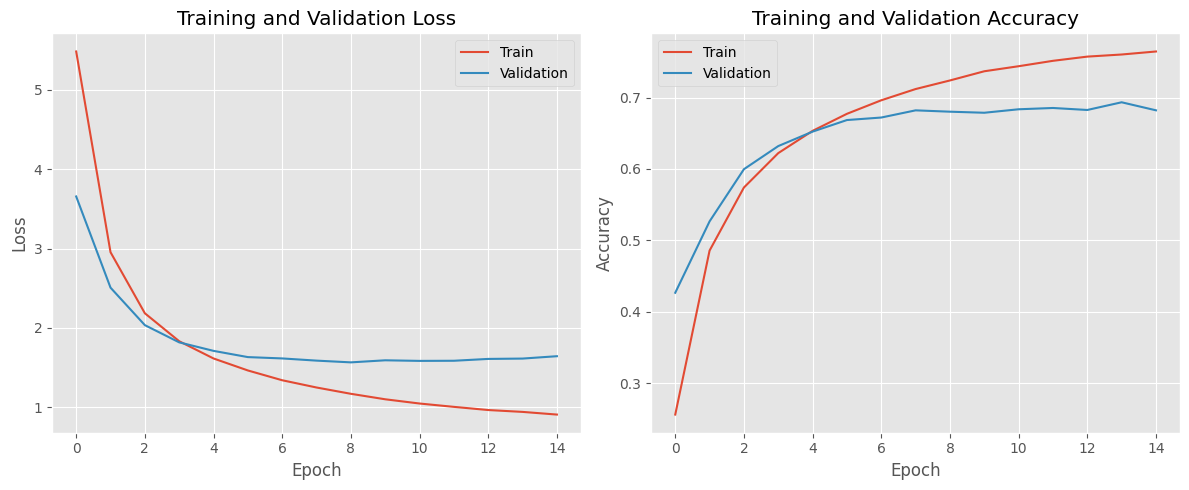

In [ ]:
#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'  # see issue #152
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# os.environ['XLA_FLAGS'] = '--xla_compile=False'
#os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda'

import matplotlib.pyplot as plt
import argparse
import json
import tensorflow as tf


class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):#for further learning rate schedule
        return {
            'd_model': str(int(self.d_model)),
            'warmup_steps': str(int(self.warmup_steps)),
        }


def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match) / tf.reduce_sum(mask)


def main(args, hparams):

    train_batches, tokenizer = get_mimic_dataset(args.csv_root, args.vocab_root, args.mimic_root,
                                                 batch_size=args.batch_size)

    val_batches, _ = get_mimic_dataset(args.csv_root, args.vocab_root, args.mimic_root,
                                       mode='val',
                                       batch_size=args.batch_size)

    csv_logger_callback = tf.keras.callbacks.CSVLogger('/content/drive/MyDrive/dissertation/Weights_re/training.log')
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'/content/drive/MyDrive/dissertation/Weights_re/{args.model_name}.tf',
        save_weights_only=True,
        monitor='val_masked_accuracy',
        mode='max',
        save_best_only=True)

    # Create a MirroredStrategy.
    #tf.distribute.MirroredStrategy(): This creates a strategy to distribute the training across multiple devices (e.g., multiple GPUs). It is useful for multi-GPU training.
    #strategy.num_replicas_in_sync: This line prints the number of devices (GPUs) available for training.
    strategy = tf.distribute.MirroredStrategy()
    print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

    # Open a strategy scope.
    with strategy.scope():
        learning_rate = args.init_lr if args.init_lr is not None else \
             CustomSchedule(hparams['d_model'])

        optimizer = tf.keras.optimizers.Adam(
            learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

        transformer = Transformer(
            num_layers=hparams['num_layers'],
            d_model=hparams['d_model'],
            num_heads=hparams['num_heads'],
            dff=hparams['dff'],
            target_vocab_size=tokenizer.get_vocab_size(),
            dropout_rate=hparams['dropout_rate'],
            input_shape=(224, 224, 3),
            classifier_weights=args.Chest_weight)

        transformer.compile(
            loss=masked_loss,
            optimizer=optimizer,
            metrics=[masked_accuracy],
        )

    history = transformer.fit(
        train_batches,
        epochs=args.n_epochs,
        validation_data=val_batches,
        callbacks=[model_checkpoint_callback, csv_logger_callback]
    )
    plot_training_history(history)

def plot_training_history(history):
    plt.style.use('ggplot')

    plt.figure(figsize=(12, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['masked_accuracy'], label='Train')
    plt.plot(history.history['val_masked_accuracy'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':

    parser = argparse.ArgumentParser()
    parser.add_argument('--csv_root', default='/content/drive/MyDrive/dissertation/Transformer')
    parser.add_argument('--vocab_root', default='/content/drive/MyDrive/dissertation/Transformer')
    parser.add_argument('--mimic_root', default='/content/drive/MyDrive/dissertation/image/NLMCXR_png')
    parser.add_argument('--model_name', default='RATCHET')
    parser.add_argument('--model_params', default='/content/drive/MyDrive/dissertation/Transformer/openi-vocab.json')
    parser.add_argument('--Chest_weight', default=Chest_weight)
    parser.add_argument('--n_epochs', default=15)
    parser.add_argument('--init_lr', default=None)
    parser.add_argument('--batch_size', default=16)
    parser.add_argument('--seed', default=42)
    parser.add_argument("-f", required=False)
    args = parser.parse_args()

    # Load mode default hyperparameters and update from file if exist
    hparams = default_hparams()
    if args.model_params:
        with open(args.model_params) as json_file:
            hparams_from_file = json.load(json_file)
            hparams.update((k, hparams_from_file[k])
                           for k in set(hparams_from_file).intersection(hparams))

    # Set tensorflow random seed
    tf.random.set_seed(args.seed)

    # Run main training sequence
    main(args=args, hparams=hparams)


# run model

In [ ]:
#def load_validator():
#    validator_model = tf.keras.models.load_model('checkpoints/cxr_validator_model.tf')
#    print('Validator Model Loaded!')
#    return validator_model


def load_model():

    # Load Tokenizer
    tokenizer = ByteLevelBPETokenizer(
        '/content/drive/MyDrive/dissertation/Transformer/openi-vocab.json',
        '/content/drive/MyDrive/dissertation/Transformer/openi-merges.txt',
    )

    # Load Model
    hparams = default_hparams()
    #tf.config.run_functions_eagerly(True)
    transformer = Transformer(
            num_layers=hparams['num_layers'],
            d_model=hparams['d_model'],
            num_heads=hparams['num_heads'],
            dff=hparams['dff'],
            target_vocab_size=tokenizer.get_vocab_size(),
            dropout_rate=hparams['dropout_rate'],
            input_shape=(224, 224, 3),
            classifier_weights=Chest_weight)

    transformer.load_weights('/content/drive/MyDrive/dissertation/Weights_re/RATCHET.tf')
    print(f'Model Loaded! Checkpoint file: checkpoints/RATCHET.tf')
    return transformer, tokenizer


def top_k_logits(logits, k):
    if k == 0:
        # no truncation
        return logits

    def _top_k():
        values, _ = tf.nn.top_k(logits, k=k)
        min_values = values[:, -1, tf.newaxis]
        return tf.where(
            logits < min_values,
            tf.ones_like(logits, dtype=logits.dtype) * -1e10,
            logits,
        )
    return tf.cond(
       tf.equal(k, 0),
       lambda: logits,
       lambda: _top_k(),
    )



def top_p_logits(logits, p):
    """Nucleus sampling"""
    batch, _ = logits.shape.as_list()
    sorted_logits = tf.sort(logits, direction='DESCENDING', axis=-1)
    cumulative_probs = tf.cumsum(tf.nn.softmax(sorted_logits, axis=-1), axis=-1)
    indices = tf.stack([
        tf.range(0, batch),
        # number of indices to include
        tf.maximum(tf.reduce_sum(tf.cast(cumulative_probs <= p, tf.int32), axis=-1) - 1, 0),
    ], axis=-1)
    min_values = tf.gather_nd(sorted_logits, indices)
    return tf.where(
        logits < min_values,
        tf.ones_like(logits) * -1e10,
        logits,
    )


def evaluate(inp_img, tokenizer, transformer, temperature, top_k, top_p, options, seed, MAX_LENGTH=128):

    # The first token to the transformer should be the start token
    output = tf.convert_to_tensor([[tokenizer.token_to_id('<s>')]])

    for _ in range(MAX_LENGTH):

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions = transformer([inp_img, output], training=False)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1, :] / temperature  # (batch_size, vocab_size)
        predictions = top_k_logits(predictions, k=top_k)
        predictions = top_p_logits(predictions, p=top_p)

        if options == 'Greedy':
            predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)[:, tf.newaxis]
        elif options == 'Sampling':
            predicted_id = tf.random.categorical(predictions, num_samples=1, dtype=tf.int32, seed=seed)
        else:
            print('SHOULD NOT HAPPEN')
        # return the result if the predicted_id is equal to the end token
        if predicted_id == 2:  # stop token #tokenizer_en.vocab_size + 1:
            break

        # concatentate the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    # transformer([inp_img, output[:, :-1]], training=False)
    return tf.squeeze(output, axis=0)[1:], transformer.decoder.last_attn_scores

In [ ]:
transformer, tokenizer = load_model()

2023-07-26 08:58:44.567201: I Loading Pretrained DenseNet-121 weights: /content/drive/MyDrive/dissertation/brucechou1983_CheXNet_Keras_0.3.0_weights.h5
Model Loaded! Checkpoint file: checkpoints/RATCHET.tf


In [ ]:
# select ten example from test dataset
if __name__ == '__main__':

    parser = argparse.ArgumentParser()
    parser.add_argument('--options', default='Sampling')
    parser.add_argument('--inp_folder', default='inp_folder')
    parser.add_argument('--out_folder', default='out_folder')
    parser.add_argument('--temperature', default=1.)
    parser.add_argument('--top_k', default=0)
    parser.add_argument('--top_p', default=1.)
    parser.add_argument('--seed', default=42)
    parser.add_argument("-f", required=False)
    args = parser.parse_args()

    #tf.config.set_visible_devices([], 'GPU')

    #transformer, tokenizer = load_model()
    #cxr_validator_model = load_validator()

    inp_folder = "/content/drive/MyDrive/image/NLMCXR_png"
    images = glob.glob(os.path.join(args.inp_folder, '*'))
    #print(images)
    images = ["/content/drive/MyDrive/dissertation/image/NLMCXR_png/CXR2320_IM-0894-1001.png",
          "/content/drive/MyDrive/dissertation/image/NLMCXR_png/CXR2558_IM-1062-10001.png",
              "/content/drive/MyDrive/dissertation/image/NLMCXR_png/CXR3980_IM-2039-1001.png",
              "/content/drive/MyDrive/dissertation/image/NLMCXR_png/CXR2345_IM-0910-1001.png",
              "/content/drive/MyDrive/dissertation/image/NLMCXR_png/CXR1440_IM-0284-1001.png",
              "/content/drive/MyDrive/dissertation/image/NLMCXR_png/CXR340_IM-1644-1001.png",
              "/content/drive/MyDrive/dissertation/image/NLMCXR_png/CXR1979_IM-0637-1001.png",
              "/content/drive/MyDrive/dissertation/image/NLMCXR_png/CXR1039_IM-0030-1002.png",
              "/content/drive/MyDrive/dissertation/image/NLMCXR_png/CXR3452_IM-1675-1001.png",
              "/content/drive/MyDrive/dissertation/image/NLMCXR_png/CXR1330_IM-0213-1001.png"]
    generated_report = []
    test_number = 0
    for image in images:
        test_number +=1
        if not image.lower().endswith(('.png', '.jpg', '.jpeg')):
            print(f'file {image} is not of image type: "png", "jpg" or "jpeg". Skipping... ')
            continue

        print(f'Generating Report for {os.path.basename(image)}')

        # Read input image with size [1, H, W, 3] and range (0, 255)
        #img_array = imageio.imread(image, as_gray=False)[None, ..., None]
        #image = inp_folder + str(image)
        img_array = cv2.imread(image)

        # Convert image to float values in (0, 1)
        img_array = tf.image.convert_image_dtype(img_array.astype('uint8'), tf.float32)

        # Resize image with padding to [1, 224, 224, 3]
        img_array = tf.image.resize_with_pad(img_array, 224, 224, method=tf.image.ResizeMethod.BILINEAR)

        img_array = tf.expand_dims(img_array, axis=0)

        # Check image is CXR
        #valid = tf.nn.sigmoid(cxr_validator_model(img_array))
        #if valid < 0.1:
        #    continue

        # Generate radiology report
        result, attention_weights = evaluate(img_array, tokenizer, transformer,
                                             args.temperature, args.top_k, args.top_p,
                                             args.options, args.seed)
        predicted_sentence = tokenizer.decode(result)
        generated_report.append(predicted_sentence)
        print(generated_report)


Generating Report for CXR2320_IM-0894-1001.png
[' the eamination consists frontal and lateral radiographs the chest .  the cardiomediastinal contours are within normal limits .  pulmonary vascularity within normal limits .  no focal consolidation pleural effusion pneumothora identified .  no significant apparent acute osseous abnormalities identified .  ']
Generating Report for CXR2558_IM-1062-10001.png
[' the eamination consists frontal and lateral radiographs the chest .  the cardiomediastinal contours are within normal limits .  pulmonary vascularity within normal limits .  no focal consolidation pleural effusion pneumothora identified .  no significant apparent acute osseous abnormalities identified .  ', ' the cardiac contours are within normal limits .  the lungs are with no focal airspace disease .  no pleural effusion pneumothora .  there has been placed the left .  hilar mildly tortuous and left hem pulmonary vascularity .  there bony .  ']
Generating Report for CXR3980_IM-203

In [ ]:
for report in generated_report:
  print(report)

 the eamination consists frontal and lateral radiographs the chest .  the cardiomediastinal contours are within normal limits .  pulmonary vascularity within normal limits .  no focal consolidation pleural effusion pneumothora identified .  no significant apparent acute osseous abnormalities identified .  
 the cardiac contours are within normal limits .  the lungs are with no focal airspace disease .  no pleural effusion pneumothora .  there has been placed the left .  hilar mildly tortuous and left hem pulmonary vascularity .  there bony .  
 the interval heart size has developed the left lower lobe appearance .  stable appearance the left lower lobe opacities .  left retrocardiac opacity has developed .  no pneumothora .  leftsided tunneled catheter leftsided aeration the left infrahilar overlying cervical aorta .  no focal infiltrates .  normal heart size .  
 there are no focal areas consolidation .  no suspicious pulmonary opacities .  heart size within normal limits .  no pleura

# generting reports

In [ ]:
# generte 50 reports to evaluate
if __name__ == '__main__':

    parser = argparse.ArgumentParser()
    parser.add_argument('--csv_root', default='/content/drive/MyDrive/dissertation/Transformer/')
    parser.add_argument('--vocab_root', default='/content/drive/MyDrive/dissertation/Transformer/')
    parser.add_argument('--mimic_root', default='/content/drive/MyDrive/image/NLMCXR_png/')
    parser.add_argument('--model', default='/content/checkpoints/RATCHET.tf')
    parser.add_argument('--model_params', default='/content/drive/MyDrive/dissertation/Transformer/hparams.json')
    parser.add_argument('--batch_size', default=1)
    parser.add_argument('--seed', default=42)
    parser.add_argument('--options', default='Sampling')
    parser.add_argument('--inp_folder', default='inp_folder')
    parser.add_argument('--out_folder', default='out_folder')
    parser.add_argument('--temperature', default=1.)
    parser.add_argument('--top_k', default=0)
    parser.add_argument('--top_p', default=1.)
    parser.add_argument("-f", required=False)
    args = parser.parse_args()
    #################### Run inference ####################
    pred_txt = dict()
    true_txt = dict()
    inp_folder = "/content/drive/MyDrive/dissertation/image/NLMCXR_png/"
    test_number = 0
    for image,real_report in tqdm(zip(test["Image1"], test["Report"]), unit="item"):
        test_number+=1
        if not image.lower().endswith(('.png', '.jpg', '.jpeg')):
            print(f'file {image} is not of image type: "png", "jpg" or "jpeg". Skipping... ')
            continue

        #print(f'Generating Report for {os.path.basename(image)}')

        # Read input image with size [1, H, W, 3] and range (0, 255)
        #img_array = imageio.imread(image, as_gray=False)[None, ..., None]
        image = inp_folder + str(image)
        true_txt[image] = real_report

        img_array = cv2.imread(image)

        # Convert image to float values in (0, 1)
        img_array = tf.image.convert_image_dtype(img_array.astype('uint8'), tf.float32)

        # Resize image with padding to [1, 224, 224, 3]
        img_array = tf.image.resize_with_pad(img_array, 224, 224, method=tf.image.ResizeMethod.BILINEAR)

        img_array = tf.expand_dims(img_array, axis=0)

        # Check image is CXR
        #valid = tf.nn.sigmoid(cxr_validator_model(img_array))
        #if valid < 0.1:
        #    continue

        # Generate radiology report
        result, attention_weights = evaluate(img_array, tokenizer, transformer,
                                             args.temperature, args.top_k, args.top_p,
                                             args.options, args.seed)
        pred_txt[image] = tokenizer.decode(result)
        pred_txt_df = pd.DataFrame.from_dict(pred_txt, orient='index')
        true_txt_df = pd.DataFrame.from_dict(true_txt, orient='index')

        pred_txt_df.to_csv('/content/drive/MyDrive/dissertation/Transformer/tmp/all_pred.csv', index=False, header=False)
        true_txt_df.to_csv('/content/drive/MyDrive/dissertation/Transformer/tmp/all_true.csv', index=False, header=False)
        if test_number >50:
          break




            # Load mode default hyperparameters and update from file if exist
    hparams = default_hparams()
    if args.model_params:
        with open(args.model_params) as json_file:
            hparams_from_file = json.load(json_file)
            hparams.update((k, hparams_from_file[k])
                           for k in set(hparams_from_file).intersection(hparams))


50item [11:18, 13.56s/item]


# nlp evaluation

## Rouge

In [ ]:
def my_lcs(string, sub):
    """
    Calculates longest common subsequence for a pair of tokenized strings
    :param string : list of str : tokens from a string split using whitespace
    :param sub : list of str : shorter string, also split using whitespace
    :returns: length (list of int): length of the longest common subsequence between the two strings

    Note: my_lcs only gives length of the longest common subsequence, not the actual LCS
    """
    if(len(string)< len(sub)):
        sub, string = string, sub

    lengths = [[0 for i in range(0,len(sub)+1)] for j in range(0,len(string)+1)]

    for j in range(1,len(sub)+1):
        for i in range(1,len(string)+1):
            if(string[i-1] == sub[j-1]):
                lengths[i][j] = lengths[i-1][j-1] + 1
            else:
                lengths[i][j] = max(lengths[i-1][j] , lengths[i][j-1])

    return lengths[len(string)][len(sub)]

class Rouge():
    '''
    Class for computing ROUGE-L score for a set of candidate sentences for the MS COCO test set

    '''
    def __init__(self):
        # vrama91: updated the value below based on discussion with Hovey
        self.beta = 1.2

    def calc_score(self, candidate, refs):
        """
        Compute ROUGE-L score given one candidate and references for an image
        :param candidate: str : candidate sentence to be evaluated
        :param refs: list of str : COCO reference sentences for the particular image to be evaluated
        :returns score: int (ROUGE-L score for the candidate evaluated against references)
        """
        assert(len(candidate)==1)
        assert(len(refs)>0)
        prec = []
        rec = []

        # split into tokens
        token_c = candidate[0].split(" ")

        for reference in refs:
            # split into tokens
            token_r = reference.split(" ")
            # compute the longest common subsequence
            lcs = my_lcs(token_r, token_c)
            prec.append(lcs/float(len(token_c)))
            rec.append(lcs/float(len(token_r)))

        prec_max = max(prec)
        rec_max = max(rec)

        if(prec_max!=0 and rec_max !=0):
            score = ((1 + self.beta**2)*prec_max*rec_max)/float(rec_max + self.beta**2*prec_max)
        else:
            score = 0.0
        return score

    def compute_score(self, gts, res):
        """
        Computes Rouge-L score given a set of reference and candidate sentences for the dataset
        Invoked by evaluate_captions.py
        :param hypo_for_image: dict : candidate / test sentences with "image name" key and "tokenized sentences" as values
        :param ref_for_image: dict : reference MS-COCO sentences with "image name" key and "tokenized sentences" as values
        :returns: average_score: float (mean ROUGE-L score computed by averaging scores for all the images)
        """
        assert(gts.keys() == res.keys())
        imgIds = gts.keys()

        score = []
        for id in imgIds:
            hypo = res[id]
            ref  = gts[id]

            score.append(self.calc_score(hypo, ref))

            # Sanity check.
            assert(type(hypo) is list)
            assert(len(hypo) == 1)
            assert(type(ref) is list)
            assert(len(ref) > 0)

        average_score = np.mean(np.array(score))
        return average_score, np.array(score)

    def method(self):
        return "Rouge"

## Bleu

In [ ]:
'''Provides:
cook_refs(refs, n=4): Transform a list of reference sentences as strings into a form usable by cook_test().
cook_test(test, refs, n=4): Transform a test sentence as a string (together with the cooked reference sentences) into a form usable by score_cooked().
'''

def precook(s, n=4, out=False):
    """Takes a string as input and returns an object that can be given to
    either cook_refs or cook_test. This is optional: cook_refs and cook_test
    can take string arguments as well."""
    words = s.split()
    counts = defaultdict(int)
    for k in range(1,n+1):
        for i in range(len(words)-k+1):
            ngram = tuple(words[i:i+k])
            counts[ngram] += 1
    return (len(words), counts)

def cook_refs(refs, eff=None, n=4): ## lhuang: oracle will call with "average"
    '''Takes a list of reference sentences for a single segment
    and returns an object that encapsulates everything that BLEU
    needs to know about them.'''

    reflen = []
    maxcounts = dict()
    for ref in refs:
        rl, counts = precook(ref, n)
        reflen.append(rl)
        for (ngram,count) in counts.items():
            maxcounts[ngram] = max(maxcounts.get(ngram,0), count)

    # Calculate effective reference sentence length.
    if eff == "shortest":
        reflen = min(reflen)
    elif eff == "average":
        reflen = float(sum(reflen))/len(reflen)

    ## lhuang: N.B.: leave reflen computaiton to the very end!!

    ## lhuang: N.B.: in case of "closest", keep a list of reflens!! (bad design)

    return (reflen, maxcounts)

def cook_test(test, refs, eff=None, n=4):
    '''Takes a test sentence and returns an object that
    encapsulates everything that BLEU needs to know about it.'''

    reflen, refmaxcounts = refs
    testlen, counts = precook(test, n, True)

    result = dict()

    # Calculate effective reference sentence length.

    if eff == "closest":
        result["reflen"] = min((abs(l-testlen), l) for l in reflen)[1]
    else: ## i.e., "average" or "shortest" or None
        result["reflen"] = reflen

    result["testlen"] = testlen

    result["guess"] = [max(0,testlen-k+1) for k in range(1,n+1)]

    result['correct'] = [0]*n
    for (ngram, count) in counts.items():
        result["correct"][len(ngram)-1] += min(refmaxcounts.get(ngram,0), count)

    return result

class BleuScorer(object):
    """Bleu scorer.
    """

    __slots__ = "n", "crefs", "ctest", "_score", "_ratio", "_testlen", "_reflen", "special_reflen"
    # special_reflen is used in oracle (proportional effective ref len for a node).

    def copy(self):
        ''' copy the refs.'''
        new = BleuScorer(n=self.n)
        new.ctest = copy.copy(self.ctest)
        new.crefs = copy.copy(self.crefs)
        new._score = None
        return new

    def __init__(self, test=None, refs=None, n=4, special_reflen=None):
        ''' singular instance '''

        self.n = n
        self.crefs = []
        self.ctest = []
        self.cook_append(test, refs)
        self.special_reflen = special_reflen

    def cook_append(self, test, refs):
        '''called by constructor and __iadd__ to avoid creating new instances.'''

        if refs is not None:
            self.crefs.append(cook_refs(refs))
            if test is not None:
                cooked_test = cook_test(test, self.crefs[-1])
                self.ctest.append(cooked_test) ## N.B.: -1
            else:
                self.ctest.append(None) # lens of crefs and ctest have to match

        self._score = None ## need to recompute

    def ratio(self, option=None):
        self.compute_score(option=option)
        return self._ratio

    def score_ratio(self, option=None):
        '''return (bleu, len_ratio) pair'''
        return (self.fscore(option=option), self.ratio(option=option))

    def score_ratio_str(self, option=None):
        return "%.4f (%.2f)" % self.score_ratio(option)

    def reflen(self, option=None):
        self.compute_score(option=option)
        return self._reflen

    def testlen(self, option=None):
        self.compute_score(option=option)
        return self._testlen

    def retest(self, new_test):
        if type(new_test) is str:
            new_test = [new_test]
        assert len(new_test) == len(self.crefs), new_test
        self.ctest = []
        for t, rs in zip(new_test, self.crefs):
            self.ctest.append(cook_test(t, rs))
        self._score = None

        return self

    def rescore(self, new_test):
        ''' replace test(s) with new test(s), and returns the new score.'''

        return self.retest(new_test).compute_score()

    def size(self):
        assert len(self.crefs) == len(self.ctest), "refs/test mismatch! %d<>%d" % (len(self.crefs), len(self.ctest))
        return len(self.crefs)

    def __iadd__(self, other):
        '''add an instance (e.g., from another sentence).'''

        if type(other) is tuple:
            ## avoid creating new BleuScorer instances
            self.cook_append(other[0], other[1])
        else:
            assert self.compatible(other), "incompatible BLEUs."
            self.ctest.extend(other.ctest)
            self.crefs.extend(other.crefs)
            self._score = None ## need to recompute

        return self

    def compatible(self, other):
        return isinstance(other, BleuScorer) and self.n == other.n

    def single_reflen(self, option="average"):
        return self._single_reflen(self.crefs[0][0], option)

    def _single_reflen(self, reflens, option=None, testlen=None):

        if option == "shortest":
            reflen = min(reflens)
        elif option == "average":
            reflen = float(sum(reflens))/len(reflens)
        elif option == "closest":
            reflen = min((abs(l-testlen), l) for l in reflens)[1]
        else:
            assert False, "unsupported reflen option %s" % option

        return reflen

    def recompute_score(self, option=None, verbose=0):
        self._score = None
        return self.compute_score(option, verbose)

    def compute_score(self, option=None, verbose=0):
        n = self.n
        small = 1e-9
        tiny = 1e-15 ## so that if guess is 0 still return 0
        bleu_list = [[] for _ in range(n)]

        if self._score is not None:
            return self._score

        if option is None:
            option = "average" if len(self.crefs) == 1 else "closest"

        self._testlen = 0
        self._reflen = 0
        totalcomps = {'testlen':0, 'reflen':0, 'guess':[0]*n, 'correct':[0]*n}

        # for each sentence
        for comps in self.ctest:
            testlen = comps['testlen']
            self._testlen += testlen

            if self.special_reflen is None: ## need computation
                reflen = self._single_reflen(comps['reflen'], option, testlen)
            else:
                reflen = self.special_reflen

            self._reflen += reflen

            for key in ['guess','correct']:
                for k in range(n):
                    totalcomps[key][k] += comps[key][k]

            # append per image bleu score
            bleu = 1.
            for k in range(n):
                bleu *= (float(comps['correct'][k]) + tiny) \
                        /(float(comps['guess'][k]) + small)
                bleu_list[k].append(bleu ** (1./(k+1)))
            ratio = (testlen + tiny) / (reflen + small) ## N.B.: avoid zero division
            if ratio < 1:
                for k in range(n):
                    bleu_list[k][-1] *= math.exp(1 - 1/ratio)

            if verbose > 1:
                print(comps, reflen)

        totalcomps['reflen'] = self._reflen
        totalcomps['testlen'] = self._testlen

        bleus = []
        bleu = 1.
        for k in range(n):
            bleu *= float(totalcomps['correct'][k] + tiny) \
                    / (totalcomps['guess'][k] + small)
            bleus.append(bleu ** (1./(k+1)))
        ratio = (self._testlen + tiny) / (self._reflen + small) ## N.B.: avoid zero division
        if ratio < 1:
            for k in range(n):
                bleus[k] *= math.exp(1 - 1/ratio)

        if verbose > 0:
            print(totalcomps)
            print("ratio:", ratio)

        self._score = bleus
        return self._score, bleu_list

In [ ]:

class Bleu:
    def __init__(self, n=4):
        # default compute Blue score up to 4
        self._n = n
        self._hypo_for_image = {}
        self.ref_for_image = {}

    def compute_score(self, gts, res):

        assert(gts.keys() == res.keys())
        imgIds = gts.keys()

        bleu_scorer = BleuScorer(n=self._n)
        for id in imgIds:
            hypo = res[id]
            ref = gts[id]

            # Sanity check.
            assert(type(hypo) is list)
            assert(len(hypo) == 1)
            assert(type(ref) is list)
            assert(len(ref) >= 1)

            bleu_scorer += (hypo[0], ref)

        #score, scores = bleu_scorer.compute_score(option='shortest')
        score, scores = bleu_scorer.compute_score(option='closest', verbose=1)
        #score, scores = bleu_scorer.compute_score(option='average', verbose=1)

        # return (bleu, bleu_info)
        return score, scores

    def method(self):
        return "Bleu"

## Cider

In [ ]:
#!/usr/bin/env python
# Tsung-Yi Lin <tl483@cornell.edu>
# Ramakrishna Vedantam <vrama91@vt.edu>

def precook(s, n=4, out=False):
    """
    Takes a string as input and returns an object that can be given to
    either cook_refs or cook_test. This is optional: cook_refs and cook_test
    can take string arguments as well.
    :param s: string : sentence to be converted into ngrams
    :param n: int    : number of ngrams for which representation is calculated
    :return: term frequency vector for occuring ngrams
    """
    words = s.split()
    counts = defaultdict(int)
    for k in range(1,n+1):
        for i in range(len(words)-k+1):
            ngram = tuple(words[i:i+k])
            counts[ngram] += 1
    return counts

def cook_refs(refs, n=4): ## lhuang: oracle will call with "average"
    '''Takes a list of reference sentences for a single segment
    and returns an object that encapsulates everything that BLEU
    needs to know about them.
    :param refs: list of string : reference sentences for some image
    :param n: int : number of ngrams for which (ngram) representation is calculated
    :return: result (list of dict)
    '''
    return [precook(ref, n) for ref in refs]

def cook_test(test, n=4):
    '''Takes a test sentence and returns an object that
    encapsulates everything that BLEU needs to know about it.
    :param test: list of string : hypothesis sentence for some image
    :param n: int : number of ngrams for which (ngram) representation is calculated
    :return: result (dict)
    '''
    return precook(test, n, True)

class CiderScorer(object):
    """CIDEr scorer.
    """

    def copy(self):
        ''' copy the refs.'''
        new = CiderScorer(n=self.n)
        new.ctest = copy.copy(self.ctest)
        new.crefs = copy.copy(self.crefs)
        return new

    def __init__(self, test=None, refs=None, n=4, sigma=6.0):
        ''' singular instance '''
        self.n = n
        self.sigma = sigma
        self.crefs = []
        self.ctest = []
        self.document_frequency = defaultdict(float)
        self.cook_append(test, refs)
        self.ref_len = None

    def cook_append(self, test, refs):
        '''called by constructor and __iadd__ to avoid creating new instances.'''

        if refs is not None:
            self.crefs.append(cook_refs(refs))
            if test is not None:
                self.ctest.append(cook_test(test)) ## N.B.: -1
            else:
                self.ctest.append(None) # lens of crefs and ctest have to match

    def size(self):
        assert len(self.crefs) == len(self.ctest), "refs/test mismatch! %d<>%d" % (len(self.crefs), len(self.ctest))
        return len(self.crefs)

    def __iadd__(self, other):
        '''add an instance (e.g., from another sentence).'''

        if type(other) is tuple:
            ## avoid creating new CiderScorer instances
            self.cook_append(other[0], other[1])
        else:
            self.ctest.extend(other.ctest)
            self.crefs.extend(other.crefs)

        return self
    def compute_doc_freq(self):
        '''
        Compute term frequency for reference data.
        This will be used to compute idf (inverse document frequency later)
        The term frequency is stored in the object
        :return: None
        '''
        for refs in self.crefs:
            # refs, k ref captions of one image
            for ngram in set([ngram for ref in refs for (ngram,count) in ref.items()]):
                self.document_frequency[ngram] += 1
            # maxcounts[ngram] = max(maxcounts.get(ngram,0), count)

    def compute_cider(self):
        def counts2vec(cnts):
            """
            Function maps counts of ngram to vector of tfidf weights.
            The function returns vec, an array of dictionary that store mapping of n-gram and tf-idf weights.
            The n-th entry of array denotes length of n-grams.
            :param cnts:
            :return: vec (array of dict), norm (array of float), length (int)
            """
            vec = [defaultdict(float) for _ in range(self.n)]
            length = 0
            norm = [0.0 for _ in range(self.n)]
            for (ngram,term_freq) in cnts.items():
                # give word count 1 if it doesn't appear in reference corpus
                df = np.log(max(1.0, self.document_frequency[ngram]))
                # ngram index
                n = len(ngram)-1
                # tf (term_freq) * idf (precomputed idf) for n-grams
                vec[n][ngram] = float(term_freq)*(self.ref_len - df)
                # compute norm for the vector.  the norm will be used for computing similarity
                norm[n] += pow(vec[n][ngram], 2)

                if n == 1:
                    length += term_freq
            norm = [np.sqrt(n) for n in norm]
            return vec, norm, length

        def sim(vec_hyp, vec_ref, norm_hyp, norm_ref, length_hyp, length_ref):
            '''
            Compute the cosine similarity of two vectors.
            :param vec_hyp: array of dictionary for vector corresponding to hypothesis
            :param vec_ref: array of dictionary for vector corresponding to reference
            :param norm_hyp: array of float for vector corresponding to hypothesis
            :param norm_ref: array of float for vector corresponding to reference
            :param length_hyp: int containing length of hypothesis
            :param length_ref: int containing length of reference
            :return: array of score for each n-grams cosine similarity
            '''
            delta = float(length_hyp - length_ref)
            # measure consine similarity
            val = np.array([0.0 for _ in range(self.n)])
            for n in range(self.n):
                # ngram
                for (ngram,count) in vec_hyp[n].items():
                    # vrama91 : added clipping
                    val[n] += min(vec_hyp[n][ngram], vec_ref[n][ngram]) * vec_ref[n][ngram]

                if (norm_hyp[n] != 0) and (norm_ref[n] != 0):
                    val[n] /= (norm_hyp[n]*norm_ref[n])

                assert(not math.isnan(val[n]))
                # vrama91: added a length based gaussian penalty
                val[n] *= np.e**(-(delta**2)/(2*self.sigma**2))
            return val

        # compute log reference length
        self.ref_len = np.log(float(len(self.crefs)))

        scores = []
        for test, refs in zip(self.ctest, self.crefs):
            # compute vector for test captions
            vec, norm, length = counts2vec(test)
            # compute vector for ref captions
            score = np.array([0.0 for _ in range(self.n)])
            for ref in refs:
                vec_ref, norm_ref, length_ref = counts2vec(ref)
                score += sim(vec, vec_ref, norm, norm_ref, length, length_ref)
            # change by vrama91 - mean of ngram scores, instead of sum
            score_avg = np.mean(score)
            # divide by number of references
            score_avg /= len(refs)
            # multiply score by 10
            score_avg *= 10.0
            # append score of an image to the score list
            scores.append(score_avg)
        return scores

    def compute_score(self, option=None, verbose=0):
        # compute idf
        self.compute_doc_freq()
        # assert to check document frequency
        assert(len(self.ctest) >= max(self.document_frequency.values()))
        # compute cider score
        score = self.compute_cider()
        # debug
        # print score
        return np.mean(np.array(score)), np.array(score)


In [ ]:
class Cider:
    """
    Main Class to compute the CIDEr metric

    """
    def __init__(self, test=None, refs=None, n=4, sigma=6.0):
        # set cider to sum over 1 to 4-grams
        self._n = n
        # set the standard deviation parameter for gaussian penalty
        self._sigma = sigma

    def compute_score(self, gts, res):
        """
        Main function to compute CIDEr score
        :param  hypo_for_image (dict) : dictionary with key <image> and value <tokenized hypothesis / candidate sentence>
                ref_for_image (dict)  : dictionary with key <image> and value <tokenized reference sentence>
        :return: cider (float) : computed CIDEr score for the corpus
        """

        assert(gts.keys() == res.keys())
        imgIds = gts.keys()

        cider_scorer = CiderScorer(n=self._n, sigma=self._sigma)

        for id in imgIds:
            hypo = res[id]
            ref = gts[id]

            # Sanity check.
            assert(type(hypo) is list)
            assert(len(hypo) == 1)
            assert(type(ref) is list)
            assert(len(ref) > 0)

            cider_scorer += (hypo[0], ref)

        (score, scores) = cider_scorer.compute_score()

        return score, scores

    def method(self):
        return "CIDEr"


# evaluate score

In [ ]:


# path to the stanford corenlp jar
STANFORD_CORENLP_3_4_1_JAR = 'stanford-corenlp-3.4.1.jar'

# punctuations to be removed from the sentences
PUNCTUATIONS = ["''", "'", "``", "`", "-LRB-", "-RRB-", "-LCB-", "-RCB-", \
        ".", "?", "!", ",", ":", "-", "--", "...", ";"]

class PTBTokenizer:
    """Python wrapper of Stanford PTBTokenizer"""

    def tokenize(self, captions_for_image):
        cmd = ['java', '-cp', STANFORD_CORENLP_3_4_1_JAR, \
                'edu.stanford.nlp.process.PTBTokenizer', \
                '-preserveLines', '-lowerCase']

        # ======================================================
        # prepare data for PTB Tokenizer
        # ======================================================
        final_tokenized_captions_for_image = {}
        image_id = [k for k, v in captions_for_image.items() for _ in range(len(v))]
        sentences = '\n'.join([c['caption'].replace('\n', ' ') for k, v in captions_for_image.items() for c in v])

        # ======================================================
        # save sentences to temporary file
        # ======================================================
        path_to_jar_dirname=os.path.dirname(os.path.abspath(__file__))
        tmp_file = tempfile.NamedTemporaryFile(delete=False, dir=path_to_jar_dirname)
        tmp_file.write(sentences.encode())
        tmp_file.close()

        # ======================================================
        # tokenize sentence
        # ======================================================
        cmd.append(os.path.basename(tmp_file.name))
        p_tokenizer = subprocess.Popen(cmd, cwd=path_to_jar_dirname, \
                stdout=subprocess.PIPE)
        token_lines = p_tokenizer.communicate(input=sentences.rstrip())[0]
        token_lines = token_lines.decode()
        lines = token_lines.split('\n')
        # remove temp file
        os.remove(tmp_file.name)

        # ======================================================
        # create dictionary for tokenized captions
        # ======================================================
        for k, line in zip(image_id, lines):
            if not k in final_tokenized_captions_for_image:
                final_tokenized_captions_for_image[k] = []
            tokenized_caption = ' '.join([w for w in line.rstrip().split(' ') \
                    if w not in PUNCTUATIONS])
            final_tokenized_captions_for_image[k].append(tokenized_caption)

        return final_tokenized_captions_for_image


In [ ]:
class EvalCap:
    def __init__(self, true_df_csv, pred_df_csv):

        self.pred_df = pd.read_csv(pred_df_csv, header=None).values
        self.true_df = pd.read_csv(true_df_csv, header=None).values

        self.eval = dict()
        self.imgToEval = dict()

    def preprocess(self, s):
        s = s.replace('\n', '')
        s = s.replace('<s>', '')
        s = s.replace('</s>', '')
        # s = s.translate(str.maketrans('', '', '0123456789'))
        # s = s.translate(str.maketrans('', '', string.punctuation))
        return s

    def evaluate(self):

        gts = {}
        res = {}

        # Sanity Checks
        assert self.pred_df.shape == self.true_df.shape

        # =================================================
        # Pre-process sentences
        # =================================================
        #print("self.trye_df[1][0]:", self.true_df[1][0])
        #print("self.trye_df[2][0]:", self.true_df[2][0])
        #print("self.pred_df.shape:",self.pred_df.shape)
        print('tokenization...')
        for i in range(self.pred_df.shape[0]):
            #print(i)
            pred_text = ' '.join(word_tokenize(self.preprocess(self.pred_df[i][0])))
            #print("self.preprocess:",self.preprocess(self.pred_df[i][0]))
            #print("word_tokenize(self.process):",word_tokenize(self.preprocess(self.pred_df[i][0])))
            #print("join:",' '.join(word_tokenize(self.preprocess(self.pred_df[i][0]))))
            true_text = ' '.join(word_tokenize(self.preprocess(self.true_df[i][0])))
            #print(pred_text)
            res[i] = [pred_text]
            gts[i] = [true_text]
        #print("gts:",gts)
        #print("res:",res)
        #print(res)

        # =================================================
        # Set up scorers
        # =================================================
        print('setting up scorers...')
        scorers = [
            (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
            #(Meteor(),"METEOR"),
            (Rouge(), "ROUGE_L"),
            (Cider(), "CIDEr")
            #(Spice(), "SPICE")
        ]
        # =================================================
        # Compute scores
        # =================================================
        for scorer, method in scorers:
            print('computing %s score...'%(scorer.method()))
            M=scorer
            score, scores = M.compute_score(gts, res)
            if type(method) == list:
                for sc, scs, m in zip(score, scores, method):
                    self.setEval(sc, m)
                    self.setImgToEvalImgs(scs, gts.keys(), m)
                    print("%s: %0.3f"%(m, sc))
            else:
                self.setEval(score, method)
                self.setImgToEvalImgs(scores, gts.keys(), method)
                print("%s: %0.3f"%(method, score))
        self.setEvalImgs()

    def setEval(self, score, method):
        self.eval[method] = score

    def setImgToEvalImgs(self, scores, imgIds, method):
        for imgId, score in zip(imgIds, scores):
            if not imgId in self.imgToEval:
                self.imgToEval[imgId] = dict()
                self.imgToEval[imgId]["image_id"] = imgId
            self.imgToEval[imgId][method] = score

    def setEvalImgs(self):
        self.evalImgs = [eval for imgId, eval in self.imgToEval.items()]

# compute

In [ ]:
#true_df_csv="/content/drive/MyDrive/dissertation/Transformer/tmp/all_true_rnn.csv"
#pred_df_csv="/content/drive/MyDrive/dissertation/Transformer/tmp/all_pred_rnn.csv"

true_df_csv="/content/drive/MyDrive/dissertation/Transformer/tmp/all_true.csv"
pred_df_csv="/content/drive/MyDrive/dissertation/Transformer/tmp/all_pred.csv"

pred_df = pd.read_csv(pred_df_csv, header=None).values
true_df = pd.read_csv(true_df_csv, header=None).values
Eval=EvalCap(true_df_csv,pred_df_csv)
gts = {}
res = {}

# Sanity Checks
assert pred_df.shape == true_df.shape

for i in range(pred_df.shape[0]):
    pred_text = ' '.join(word_tokenize(Eval.preprocess(pred_df[i][0])))
    true_text = ' '.join(word_tokenize(Eval.preprocess(true_df[i][0])))
    res[i] = [pred_text]
    gts[i] = [true_text]



In [ ]:
# Create an instance of the Bleu class
bleu_calculator = Bleu(n=4)  # You can specify the value of 'n' for maximum n-gram order (default is 4)

# Calculate the BLEU score
bleu_score, bleu_scores_list = bleu_calculator.compute_score(gts, res)

# Print the overall BLEU score
print("Overall BLEU Score:", bleu_score)

# Print individual n-gram BLEU scores
for i in range(len(bleu_scores_list)):
    print(f"BLEU-{i+1}:", bleu_scores_list[i])
#Bleu(4).compute_score(gts, res)

{'testlen': 1352, 'reflen': 1432, 'guess': [1352, 1303, 1254, 1205], 'correct': [579, 179, 69, 31]}
ratio: 0.9441340782116312
Overall BLEU Score: [0.40364908632980673, 0.22861638088096878, 0.13942996409734104, 0.09004016326262458]
BLEU-1: [0.3571428571343538, 0.7407407407133059, 0.3030303030211204, 0.44098326030844565, 0.3255205016449408, 0.21951219511659734, 0.3593158883707544, 0.357142857117347, 0.30434782607372407, 0.5666666666477778, 0.4372772090045225, 0.580645161271592, 0.4150457801031469, 0.27083333332769105, 0.2621911009609273, 0.35714285711734695, 0.3999999999885715, 0.2727272727190084, 0.29301044031186685, 0.39999999998666674, 0.2545454545408265, 0.30231349655810513, 0.3643036665256173, 0.3944580857997108, 0.24348935048832623, 0.5333333333155555, 0.4437653465246747, 0.27027027026296574, 0.4458229198460465, 0.3996622737621691, 0.24875107925539972, 0.2444444444390124, 0.35483870966597303, 0.4374999999863282, 0.3079902739137641, 0.39393939392745647, 0.4444444444279836, 0.0359307

In [ ]:
rouge = Rouge()
Rouge_score, Rouge_scores_list = rouge.compute_score(gts, res)

# Print the overall Rouge score
print("Overall Rouge Score:", Rouge_score)

Overall Rouge Score: 0.30531927369791667


In [ ]:
cider_calculator = Cider(n=4, sigma=6.0)
cider_score, cider_scores_list = cider_calculator.compute_score(gts, res)

# Print the overall Rouge score
print("Overall cider Score:", cider_score)

Overall cider Score: 0.22509290735417292
